In [1]:
#hide
import sys
import numpy as np
import numpy.linalg as la
import scipy.optimize as opt
from matplotlib import pyplot as plt, animation
import proplot as plot

plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

In [2]:
#hide
sys.path.append('/Users/austin/Desktop/research/code/accphys')
from tools import matrix_lattice as ml
from tools import plotting as myplt
from tools import animation as myanim

# Nonlinear resonances

Let's create a very simple class to hold a transfer matrix and track particles.

In [306]:
def norm_mat_2D(alpha, beta):
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

def phase_adv_mat_2D(tune):
    phase_advance = 2 * np.pi * tune
    cos, sin = np.cos(phase_advance), np.sin(phase_advance)
    return np.array([[cos, sin], [-sin, cos]])

def apply(M, X):
    return np.apply_along_axis(lambda x: np.matmul(M, x), 1, X)

class Lattice:
    """Represents lattice as linear one-turn transfer matrix."""
    def __init__(self, alpha_x, alpha_y, beta_x, beta_y, tune_x, tune_y):
        self.P = np.zeros((4, 4))
        self.V = np.zeros((4, 4))
        self.M = np.zeros((4, 4))
        self.P[:2, :2] = phase_adv_mat_2D(tune_x)
        self.P[2:, 2:] = phase_adv_mat_2D(tune_y)
        self.V[:2, :2] = norm_mat_2D(alpha_x, beta_x)
        self.V[2:, 2:] = norm_mat_2D(alpha_y, beta_y)
        self.M = la.multi_dot([self.V, self.P, la.inv(self.V)])
    
    def track_part(self, x):
        """Track a single particle."""
        return np.matmul(self.M, x)
    
    def track_bunch(self, X):
        """Track a bunch of particles."""
        return apply(self.M, X)

The effect of a sextupole magnet can be approximated as a thin lens kick to the transverse particle slopes.

In [398]:
class Sextupole:
    """Represents sextupole as thin-lens kick."""
    def __init__(self, integrated_strength):
        self.S = integrated_strength
            
    def track_part(self, coords):
        if np.max(coords) < 1e20:
            x, xp, y, yp = coords
            coords[1] += -0.5 * self.S * (x**2 - y**2)
            coords[3] += self.S * x * y
        return coords
    
    def track_bunch(self, X):
        return np.apply_along_axis(self.track_part, 1, X)

In [399]:
def track(x, lattice, sextupole, nturns=0, lim=1e20):
    X = [x]
    for _ in range(nturns):
        x = lattice.track_part(x)
        x = sextupole.track_part(x)
        X.append(x)
    return np.array(X)

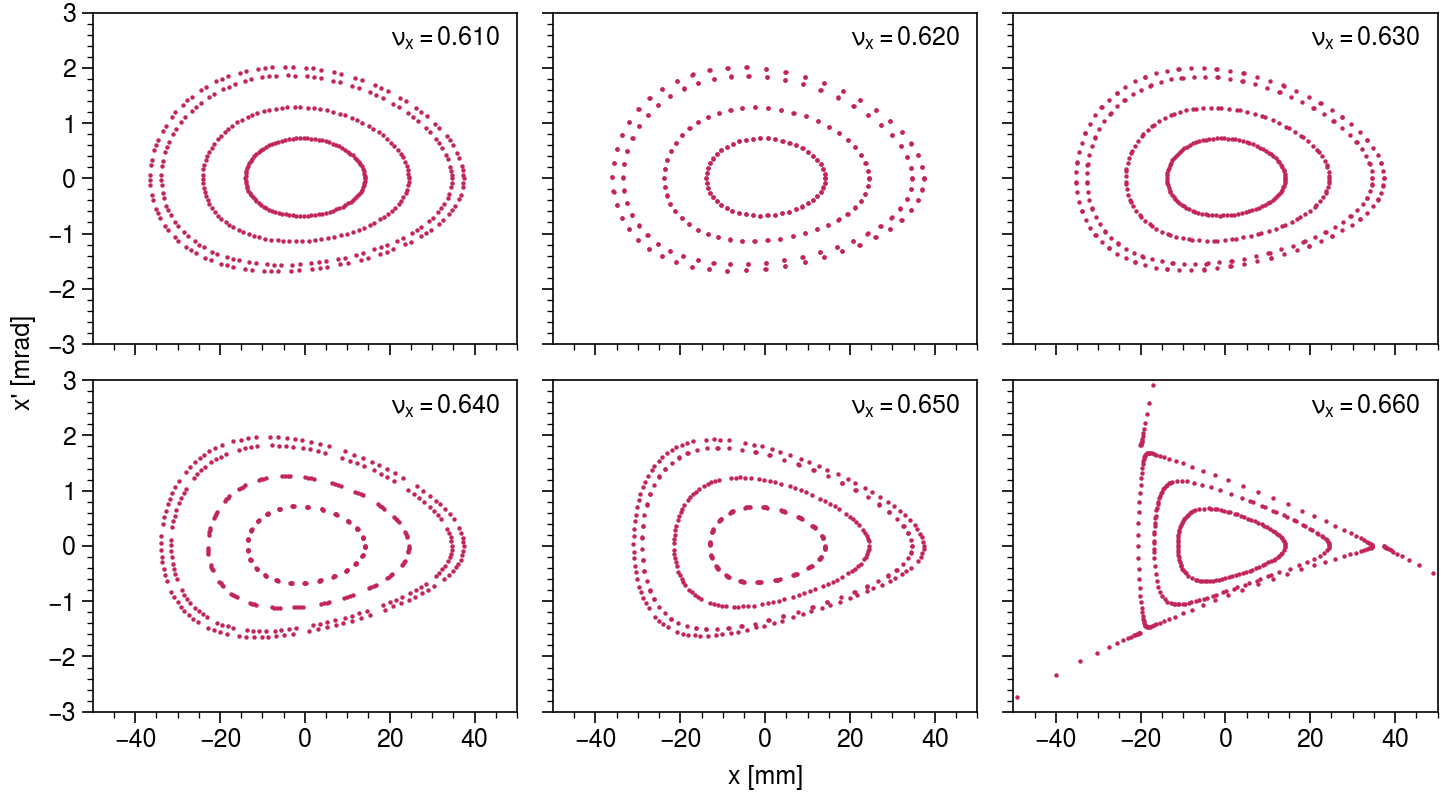

In [400]:
alpha_x = alpha_y = 0.0
beta_x = beta_y = 20.0
tune_y = 0.5
S = 0.5 # integrated sextupole field strength [m^-2]
nturns = 100

x0 = np.array([np.sqrt(beta_x), -alpha_x * np.sqrt(1 / beta_x), 
               np.sqrt(beta_y), -alpha_y * np.sqrt(1 / beta_y)])

sextupole= Sextupole(S)

tunes = np.linspace(0.61, 0.66, 6)
emittances = 1e-6 * np.array([10, 30, 60, 70])

fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(7.25, 4))
umax, upmax = (50, 3)

for ax, tune in zip(axes, tunes):
    lattice = Lattice(alpha_x, alpha_y, beta_x, beta_y, tune, tune_y)
    arrays = []
    for emittance in emittances:
        x = np.sqrt(emittance) * x0
        arrays.append(track(x, lattice, sextupole, nturns))
    X = 1000 * np.vstack(arrays)
    ax.scatter(X[:, 0], X[:, 1], s=1, c='pink8')
    ax.format(xlabel='x [mm]', ylabel="x' [mrad]", xlim=(-umax, umax), ylim=(-upmax, upmax))
    ax.annotate(r'$\nu_x = {:.3f}$'.format(tune), xy=(0.7, 0.9), xycoords='axes fraction');

In [406]:
from scipy.stats import truncnorm

lattice = Lattice(alpha_x, alpha_y, beta_x, beta_y, 0.66, 0.5)
sextupole = Sextupole(0.5)

nparts = 2000
cut = 3.0
emittance = 10e-6
X = truncnorm.rvs(a=4*[-cut], b=4*[cut], size=(nparts, 4))
X = apply(np.sqrt(np.diag(4 * [emittance])), X)
X = apply(lattice.V, X)

nturns = 150
coords = [X]
for _ in range(nturns):
    X = lattice.track_bunch(X)
    X = sextupole.track_bunch(X)
    coords.append(X)
coords = 1000 * np.array(coords)

fig, ax = plt.subplots(figsize=(3, 3))
scale = 1.5
ax.set_xlim(-scale*umax, scale*umax)
ax.set_ylim(-scale*upmax, scale*upmax)
plt.close()

line, = ax.plot([], [], marker='.', lw=0, ms=3, c='steelblue', markeredgewidth=0, fillstyle='full')

def update(t):
    X = coords[t]
    line.set_data(X[:, 0], X[:, 1])
    ax.set_title('Turn {}'.format(t))
    
fps = 7
anim = animation.FuncAnimation(fig, update, frames=nturns, interval=1000/fps)
anim

To do: 
* Plot circle to represent beam pipe
* Color particle by alive/dead
* Neighboring plot showing % of beam remaining vs turn number.